* https://qiita.com/kazuya_minakuchi/items/42d276cb1a6e68ffa0e4 の図を作ったコード
* ※ほとんど「機械学習のエッセンス: https://www.amazon.co.jp/gp/product/4797393963/ref=ppx_yo_dt_b_search_asin_title 」の写経

In [1]:
# 必要なライブラリインポート
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt

In [2]:
# 境界線が直線で、完全に分離できない場合
class LinearSVC:
    def __init__(self, C=1.):
        self.C = C  # ハイパーパラメータを設定: 間違えを許す度合い

    def fit(self, X, y, selections=None):
        # 初期値は全部0からスタート
        a = np.zeros(X.shape[0])
        # aの初期値が0なので、これらも0からスタート
        ay = 0
        ayx = np.zeros(X.shape[1])
        
        yx = y.reshape(-1, 1)*X
        indices = np.arange(X.shape[0])    # インデックス用
        
        # 手計算では解けないので繰り返し計算で解を出す
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))  # y∇f(a)
            iydf = np.c_[indices, ydf]     # ｙにインデックス付ける
            # 今回更新するaを2つ選ぶ
            i = int(min(iydf[((a > 0) & (y > 0)) |
                             ((a < self.C) & (y < 0))],
                        key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) |
                             ((a < self.C) & (y > 0))],
                        key=itemgetter(1))[0])
            # 収束条件
            if ydf[i] >= ydf[j]:
                break
            # ayからai, ajの成分引いたやつ
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            # ai更新
            ai = ((1-y[i]*y[j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            # aj更新
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j]-ay2)*y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j]-ay2)*y[i]
            # 更新したai, ajを使ってay, ayx更新
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            # 更新してもai変わらなかったら終了
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        ind = a != 0.
        # 決定したa使ってw求める
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                   * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()

    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))

In [4]:
#点作成
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([2.5, 3])

X = np.r_[X0, X1]
y = np.array([1] * 20 + [-1] * 20)

In [5]:
# 学習
model = LinearSVC(1.0)
model.fit(X, y)

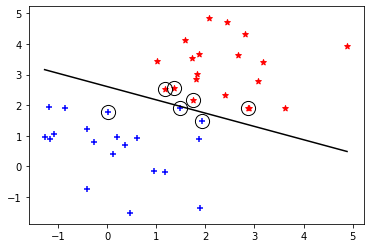

[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.45506507  0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.32816128  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  1.          0.         -0.          0.12690379]
正しく分類できた数: 40 / 40


In [7]:
np.random.seed(0)

plt.scatter(X0[:, 0], X0[:, 1], color="b", marker="+")
plt.scatter(X1[:, 0], X1[:, 1], color="r", marker="*")

#境界線引く
def f(model, x):
    return (-model.w0_ - model.w_[0] * x) / model.w_[1]
x1 = min(X[:, 0])
x2 = max(X[:, 0])
plt.plot([x1, x2], [f(model, x1), f(model, x2)], color="k")

#サポートベクターに〇つける
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
            s=200, color=(0, 0, 0, 0), edgecolor="k", marker="o")

plt.show()

print(model.a_)
print("正しく分類できた数:", (model.predict(X) == y).sum(), "/", len(X))